# Asthma BNN Classifier (Balanced, ≤ 20KB params)

This notebook trains a compact **Binarized Neural Network (BNN)** to predict asthma.

**What this version does**
- Drops **`Ethnicity`** from predictors
- Uses **unweighted BCE** (no `pos_weight`)
- **Oversamples positives** on the train split (avoid collapse without changing batch sizes)
- **Hidden sizes = [64, 32]** to keep total params well **below 20KB** (ESP32-friendly)
- Inference **matches training**: `fc → BN → hardtanh → dropout` (dropout disabled at eval)
- Saves artifacts to **`/mnt/data/bnn_artifacts`** (unchanged)


In [1]:
# === Setup ===
import os, json, math, random, numpy as np, pandas as pd
from pathlib import Path

SEED = 42
random.seed(SEED); np.random.seed(SEED)

CSV_PATH = Path('asthma_disease_data.csv')  # (unchanged path)
assert CSV_PATH.exists(), f'CSV not found: {CSV_PATH}'
df = pd.read_csv(CSV_PATH)
df.shape

(4536, 29)

## 1) Clean & Feature Selection (drop `Ethnicity`)

In [2]:
TARGET_CANDIDATES = ['Diagnosis','asthma','Asthma','is_asthmatic']
target_col = next((c for c in TARGET_CANDIDATES if c in df.columns), None)
assert target_col is not None, f'Target column not found among {TARGET_CANDIDATES}'

# Drop obvious identifiers and high-cardinality free text
drop_cols = set()
for c in df.columns:
    if c == target_col:
        continue
    if c.lower() in ['patientid','doctorincharge','id','uuid','guid','recordid','ethnicity','educationlevel','lungfunctionfev1', 'lungfunctionfvc',]:
        drop_cols.add(c)
    if df[c].dtype == 'object' and df[c].nunique(dropna=True) > 20:
        drop_cols.add(c)

# Remove all-null, near-constant, duplicates
for c in df.columns:
    if c == target_col or c in drop_cols:
        continue
    s = df[c]
    if s.isna().all():
        drop_cols.add(c)
    else:
        top_freq = s.value_counts(dropna=False).iloc[0] / len(s)
        if top_freq > 0.95:
            drop_cols.add(c)

seen = {}
for c in df.columns:
    if c == target_col or c in drop_cols:
        continue
    key = tuple(pd.util.hash_pandas_object(df[c].fillna('__NA__')).values)
    if key in seen:
        drop_cols.add(c)
    else:
        seen[key] = c

df_clean = df.drop(columns=list(drop_cols), errors='ignore').copy()

# Keep only numeric predictors
predictors = [c for c in df_clean.columns if c != target_col and pd.api.types.is_numeric_dtype(df_clean[c])]
df_clean = df_clean[predictors + [target_col]]

# --- Enforce dropping Ethnicity ---
if 'Ethnicity' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Ethnicity'])
predictors = [c for c in df_clean.columns if c != target_col]

print('Dropped columns (examples):', sorted(list(drop_cols))[:8], '...')
print('Predictors ({}):'.format(len(predictors)), predictors)
print('Target:', target_col)
df_clean.head(3)

Dropped columns (examples): ['DoctorInCharge', 'EducationLevel', 'Ethnicity', 'LungFunctionFEV1', 'LungFunctionFVC', 'PatientID'] ...
Predictors (22): ['Age', 'Gender', 'BMI', 'Smoking', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'PollutionExposure', 'PollenExposure', 'DustExposure', 'PetAllergy', 'FamilyHistoryAsthma', 'HistoryOfAllergies', 'Eczema', 'HayFever', 'GastroesophagealReflux', 'Wheezing', 'ShortnessOfBreath', 'ChestTightness', 'Coughing', 'NighttimeSymptoms', 'ExerciseInduced']
Target: Diagnosis


,Age,Gender,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,PollenExposure,DustExposure,...,Eczema,HayFever,GastroesophagealReflux,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,2.855578,0.974339,...,0,0,0,0,0,1,0,0,1,0
1,26,1,22.757042,0,5.897329,6.341014,5.153966,1.969838,7.457665,6.584631,...,0,0,0,1,0,0,1,1,1,0
2,57,0,18.395396,0,6.739367,9.196237,6.840647,1.460593,1.448189,5.445799,...,0,1,0,1,1,1,0,1,1,0


## 2) Split & Scale (unchanged batch sizes later)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = df_clean[target_col].astype(int).values
assert set(np.unique(y)).issubset({0,1}), 'Target must be binary 0/1.'
X = df_clean[predictors].astype(np.float32).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

x_mean = scaler.mean_.astype(np.float32)
x_scale= scaler.scale_.astype(np.float32)

print('Train/Test:', X_train.shape, X_test.shape)
print('Base positive rate (train):', float((y_train==1).mean()))

Train/Test: (3628, 22) (908, 22)
Base positive rate (train): 0.5


## 3) Oversample Positives (no pos_weight; no path/batch-size changes)

In [4]:

X_train_bal, y_train_bal = X_train, y_train
print('Before:', dict(zip(*np.unique(y_train, return_counts=True))))
print('After :', dict(zip(*np.unique(y_train_bal, return_counts=True))))

Before: {0: 1814, 1: 1814}
After : {0: 1814, 1: 1814}


## 4) BNN Model (hidden=[64,32], param ≤ 20KB, exact forward at train & infer)

In [5]:
import torch, torch.nn as nn, torch.nn.functional as F

# ---------- binarizers ----------
class SignBinarizeZeroToPlusOne(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x): return torch.where(x >= 0, torch.ones_like(x), -torch.ones_like(x))
    @staticmethod
    def backward(ctx, g): return g.clamp_(-1, 1)

class SignBinarizeLegacy(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x): return x.sign()   # -1, 0, +1 (0 stays 0)
    @staticmethod
    def backward(ctx, g): return g.clamp_(-1, 1)

def make_binarize(mode: str):
    mode = str(mode).lower()
    assert mode in {"legacy","z2p1"}
    return SignBinarizeLegacy.apply if mode=="legacy" else SignBinarizeZeroToPlusOne.apply

# ---------- model ----------
class BinaryLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=False, binarize_fn=None):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        nn.init.kaiming_normal_(self.weight, nonlinearity='relu')
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None
        self.binarize = binarize_fn or make_binarize("legacy")
    def forward(self, x):
        x_b = self.binarize(x)
        alpha = self.weight.detach().abs().mean(dim=1, keepdim=True)
        w_b = self.binarize(self.weight) * alpha
        return F.linear(x_b, w_b, self.bias)

class HybridBNN(nn.Module):
    def __init__(self, in_dim, hidden=[64,32], p_drop=0.1, binarize_mode="legacy"):
        super().__init__()
        self.binarize = make_binarize(binarize_mode)
        self.float1 = nn.Sequential(
            nn.Linear(in_dim, hidden[0], bias=False),
            nn.BatchNorm1d(hidden[0]),
            nn.Hardtanh()
        )
        blocks = []
        for i in range(len(hidden)-1):
            blocks += [
                BinaryLinear(hidden[i], hidden[i+1], bias=False, binarize_fn=self.binarize),
                nn.BatchNorm1d(hidden[i+1]),
                nn.Hardtanh(),
                nn.Dropout(p_drop),
            ]
        self.bin_stack = nn.Sequential(*blocks) if blocks else nn.Identity()
        self.out = BinaryLinear(hidden[-1], 1, bias=True, binarize_fn=self.binarize)
    def forward(self, x):
        x = self.float1(x)
        x = self.bin_stack(x)
        return self.out(x).squeeze(1)

## 5) Train (unweighted BCE; batch sizes unchanged)

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"

from torch.utils.data import DataLoader, TensorDataset


# DataLoaders (batch sizes unchanged)
Xtr = torch.from_numpy(X_train_bal).to(device)
ytr = torch.from_numpy(y_train_bal.astype(np.float32)).to(device)
Xte = torch.from_numpy(X_test).to(device)
yte = torch.from_numpy(y_test.astype(np.float32)).to(device)

train_loader = DataLoader(TensorDataset(Xtr,ytr), batch_size=256, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte,yte), batch_size=512, shuffle=False)

model = HybridBNN(in_dim=X_train.shape[1]).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss()  # unweighted loss

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate():
    model.eval()
    total_loss, n = 0.0, 0
    all_logits, all_y = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model(xb)
            loss = loss_fn(logits, yb)
            total_loss += float(loss.item()) * xb.size(0)
            n += xb.size(0)
            all_logits.append(logits.detach().cpu())
            all_y.append(yb.detach().cpu())
    logits = torch.cat(all_logits).numpy()
    y_true = torch.cat(all_y).numpy()
    probs = 1/(1+np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds, zero_division=0)
    try:
        auc = roc_auc_score(y_true, probs)
    except Exception:
        auc = float('nan')
    return total_loss/max(1,n), acc, f1, auc

best = {"epoch":-1, "loss":1e9, "acc":0.0, "state":None}
EPOCHS = 3000
for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
    val_loss, acc, f1, auc = evaluate()
    if val_loss < best["loss"]:
        best.update({"epoch":epoch, "loss":val_loss, "acc":acc, "state":model.state_dict()})
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | val_loss={val_loss:.4f} acc={acc:.3f} f1={f1:.3f} auc={auc:.3f}")

model.load_state_dict(best["state"])
print("Best @ epoch", best["epoch"], "val_acc", round(best["acc"],3))

Epoch 01 | val_loss=0.7211 acc=0.550 f1=0.585 auc=0.573
Epoch 05 | val_loss=0.6084 acc=0.664 f1=0.639 auc=0.734
Epoch 10 | val_loss=0.5590 acc=0.704 f1=0.701 auc=0.787
Epoch 15 | val_loss=0.5146 acc=0.765 f1=0.769 auc=0.826
Epoch 20 | val_loss=0.4280 acc=0.816 f1=0.828 auc=0.890
Epoch 25 | val_loss=0.4038 acc=0.827 f1=0.837 auc=0.901
Epoch 30 | val_loss=0.3291 acc=0.889 f1=0.896 auc=0.934
Epoch 35 | val_loss=0.3101 acc=0.887 f1=0.893 auc=0.943
Epoch 40 | val_loss=0.2445 acc=0.901 f1=0.905 auc=0.964
Epoch 45 | val_loss=0.2611 acc=0.894 f1=0.900 auc=0.963
Epoch 50 | val_loss=0.2180 acc=0.922 f1=0.924 auc=0.968
Epoch 55 | val_loss=0.1905 acc=0.946 f1=0.948 auc=0.975
Epoch 60 | val_loss=0.2038 acc=0.934 f1=0.937 auc=0.973
Epoch 65 | val_loss=0.1906 acc=0.937 f1=0.939 auc=0.975
Epoch 70 | val_loss=0.2213 acc=0.927 f1=0.929 auc=0.968
Epoch 75 | val_loss=0.2102 acc=0.936 f1=0.939 auc=0.970
Epoch 80 | val_loss=0.2155 acc=0.943 f1=0.945 auc=0.972
Epoch 85 | val_loss=0.1740 acc=0.955 f1=0.957 au

## 6) Evaluation + Threshold Sweep (find a useful operating point)

              precision    recall  f1-score   support

           0     1.0000    0.9824    0.9911       454
           1     0.9827    1.0000    0.9913       454

    accuracy                         0.9912       908
   macro avg     0.9913    0.9912    0.9912       908
weighted avg     0.9913    0.9912    0.9912       908

ROC-AUC: 1.0
PR-AUC : 1.0


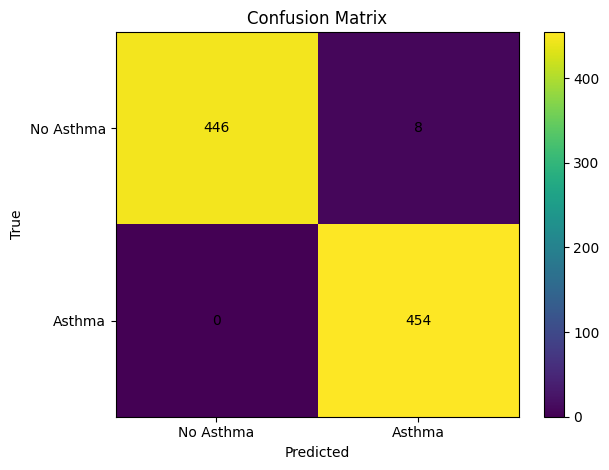

Best threshold: 0.9994687438011169 Best F1: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       454
           1     1.0000    1.0000    1.0000       454

    accuracy                         1.0000       908
   macro avg     1.0000    1.0000    1.0000       908
weighted avg     1.0000    1.0000    1.0000       908



In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    logits = model(torch.from_numpy(X_test).to(device)).cpu().numpy()
probs = 1/(1+np.exp(-logits))
preds = (probs>=0.5).astype(int)

print(classification_report(y_test, preds, digits=4))
try:
    print('ROC-AUC:', roc_auc_score(y_test, probs))
    print('PR-AUC :', average_precision_score(y_test, probs))
except Exception as e:
    print('AUC error:', e)

# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(); plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion Matrix'); plt.colorbar();
plt.xticks([0,1], ['No Asthma','Asthma']); plt.yticks([0,1], ['No Asthma','Asthma'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

# Threshold sweep (F1)
prec, rec, thr = precision_recall_curve(y_test, probs)
best_t, best_f1 = 0.5, -1.0
for t in np.unique(np.clip(thr, 0, 1)):
    pred = (probs >= t).astype(int)
    f1 = f1_score(y_test, pred, zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, float(t)
print('Best threshold:', best_t, 'Best F1:', round(best_f1,4))
print(classification_report(y_test, (probs>=best_t).astype(int), digits=4))

## 7) Save Artifacts (unchanged path)

In [8]:
out_dir = Path('bnn_artifacts')  # unchanged
out_dir.mkdir(exist_ok=True, parents=True)
torch.save(model.state_dict(), out_dir/'bnn_state.pt')
with open(out_dir/'scaler.json','w') as f:
    json.dump({'mean': x_mean.tolist(), 'scale': x_scale.tolist(), 'predictors': predictors, 'target': target_col}, f)
print('Saved to', out_dir)

Saved to bnn_artifacts


## 8) Robust Prediction Helper (exact-forward; path auto-discovery inc. `/mnt/data/bnn_artifacts`)

In [9]:
_CANDIDATE_DIRS = ['bnn_artifacts','./bnn_artifacts','/mnt/data/bnn_artifacts', str(Path.cwd()/'bnn_artifacts')]
_model_cache = {"legacy": None, "z2p1": None}

def _find_art_dir():
    for p in _CANDIDATE_DIRS:
        d = Path(p)
        if (d/'bnn_state.pt').exists() and (d/'scaler.json').exists():
            return d
    raise FileNotFoundError('Artifacts not found in: ' + ', '.join(_CANDIDATE_DIRS))

def _infer_hidden_from_state(state, input_dim):
    w2d = [(k,v) for k,v in state.items() if k.endswith('.weight') and hasattr(v,'ndim') and v.ndim==2]
    hidden, first = [], False
    for k,W in w2d:
        out_f, in_f = W.shape
        if not first:
            if in_f != input_dim: continue
            hidden.append(out_f); first = True; continue
        if out_f == 1: break
        hidden.append(out_f)
    if not hidden: raise ValueError("Failed to infer hidden sizes from checkpoint.")
    return hidden

def _build_bnn_from_state(state, input_dim, p_drop=0.1, binarize_mode="legacy"):
    hidden = _infer_hidden_from_state(state, input_dim)
    m = HybridBNN(input_dim, hidden, p_drop=p_drop, binarize_mode=binarize_mode)
    m._inferred_hidden = hidden
    return m

def _load_artifacts_for_infer(binarize_mode="legacy"):
    art = _find_art_dir()
    meta = json.loads((art/'scaler.json').read_text())
    preds  = meta['predictors']
    x_mean = np.array(meta['mean'],  dtype=np.float32)
    x_scale= np.array(meta['scale'], dtype=np.float32)
    # honor metadata hint if present
    bm = str(meta.get('binarize_mode', binarize_mode)).lower()
    if bm in {"legacy","z2p1"}: binarize_mode = bm
    state = torch.load(art/'bnn_state.pt', map_location='cpu')
    m = _build_bnn_from_state(state, input_dim=len(preds), p_drop=0.1, binarize_mode=binarize_mode)
    m.load_state_dict(state, strict=True)
    m.eval()
    print(f"✅ Loaded from {art} | hidden sizes: {m._inferred_hidden} | binarize={binarize_mode}")
    return m, preds, x_mean, x_scale

def _get_model(binarize_mode="legacy"):
    if _model_cache[binarize_mode] is None:
        _model_cache[binarize_mode] = _load_artifacts_for_infer(binarize_mode)
    return _model_cache[binarize_mode]

def reset_infer_cache():
    for k in _model_cache: _model_cache[k] = None

# ---------- preprocessing & prediction ----------
def _prep_df(df_like, predictors, x_mean, x_scale, strict=False):
    if isinstance(df_like, dict):
        df = pd.DataFrame([df_like])
    elif isinstance(df_like, pd.Series):
        df = pd.DataFrame([df_like.to_dict()])
    else:
        df = df_like.copy()

    # enforce exact predictor order; fill missing with training mean (warn)
    missing = [c for c in predictors if c not in df.columns]
    if missing:
        if strict:
            raise KeyError(f"Missing predictors: {missing}")
        print(f"[WARN] Filling {len(missing)} missing column(s) with training mean: {missing[:8]}{'...' if len(missing)>8 else ''}")
        for c, mu in zip(predictors, x_mean):
            if c not in df.columns:
                df[c] = float(mu)

    X = df[predictors].astype(np.float32).values
    Xn = (X - x_mean) / (x_scale + 1e-8)
    return Xn

@torch.inference_mode()
def predict_asthma(df_like, threshold: float = 0.5, binarize_mode="legacy", strict=False, verbose=False):
    m, preds, mu, sigma = _get_model(binarize_mode)
    Xn = _prep_df(df_like, preds, mu, sigma, strict=strict)
    lg = m(torch.from_numpy(Xn)).cpu().numpy()
    pr = 1/(1+np.exp(-lg))
    lb = (pr >= float(threshold)).astype(np.int32)
    if verbose:
        print(f"[{binarize_mode}] logits: min={lg.min():.4f} max={lg.max():.4f} mean={lg.mean():.4f}")
        print(f"[{binarize_mode}] probs : min={pr.min():.4f} max={pr.max():.4f} mean={pr.mean():.4f}")
    return pr, lb, lg

def compare_binarize_modes(df_like, threshold=0.5, strict=False):
    out = {}
    for mode in ["legacy","z2p1"]:
        try:
            out[mode] = predict_asthma(df_like, threshold, binarize_mode=mode, strict=strict, verbose=True)
        except Exception as e:
            print(f"[{mode}] ERROR:", e); out[mode]=None
    return out

## 9) Parameter Size (KiB) — confirm ≤ 20KB total (fold BN for deployment)

In [10]:
# ---------- size estimator ----------
def param_size_kib(in_dim: int, hidden: list, out_dim=1, first_layer_float=True, bn_mode="fold"):
    assert bn_mode in {"fold","affine","all"}
    dims = [in_dim] + list(hidden) + [out_dim]
    weight_bytes = 0
    for i in range(len(dims)-1):
        fan_in, fan_out = dims[i], dims[i+1]
        if i==0 and first_layer_float:
            weight_bytes += fan_in*fan_out*4
        else:
            weight_bytes += ((fan_in*fan_out) + 7)//8
    bias_bytes = 4  # output bias only in this architecture
    if bn_mode=="fold":
        bn_bytes = 0
    else:
        bn_channels = hidden[0] + sum(hidden[1:])
        bn_bytes = (2 if bn_mode=="affine" else 4)*bn_channels*4
    total = weight_bytes + bias_bytes + bn_bytes
    return {
        "weight_kib": round(weight_bytes/1024,4),
        "bias_kib": round(bias_bytes/1024,4),
        "bn_kib": round(bn_bytes/1024,4),
        "total_kib": round(total/1024,4),
    }

def print_loaded_model_size(first_layer_float=True, bn_mode="fold", binarize_mode="legacy"):
    m, preds, *_ = _get_model(binarize_mode)
    sizes = param_size_kib(len(preds), m._inferred_hidden, 1, first_layer_float, bn_mode)
    print(f"Estimated deployment size (binarize={binarize_mode}, BN={bn_mode}):")
    for k,v in sizes.items(): print(f"  {k}: {v} KiB")
    return sizes

## 10) Quick Usage Examples (unchanged paths)

In [11]:
# Batch check
probs_b, labels_b, logits_b = predict_asthma(pd.read_csv('asthma_disease_data.csv').head(8))
print('Batch probs:', probs_b.round(4))
print('Batch labels:', labels_b)
print('Batch logits:', logits_b.round(4))

# Strong positive (obvious asthma) example row
row_asthma = {
    'Age': 25,
    'Gender': 1,
    'BMI': 39.29764739,
    'Smoking': 0,
    'PhysicalActivity': 8.899044846,
    'DietQuality': 0.325397968,
    'SleepQuality': 5.524751815,
    'PollutionExposure': 7.854229872,
    'PollenExposure': 0.498309572,
    'DustExposure': 5.133637227,
    'PetAllergy': 0,
    'FamilyHistoryAsthma': 1,
    'HistoryOfAllergies': 0,
    'Eczema': 0,
    'HayFever': 1,
    'GastroesophagealReflux': 0,
    'Wheezing': 1,
    'ShortnessOfBreath': 0,
    'ChestTightness': 0,
    'Coughing': 0,
    'NighttimeSymptoms': 0,
    'ExerciseInduced': 1
}

p_asthma, l_asthma, logits = predict_asthma(row_asthma, threshold=0.5)
print('Asthma prob (obvious case):', float(p_asthma[0]), 'Label:', int(l_asthma[0]))
print('Logit:', float(logits[0]))



✅ Loaded from bnn_artifacts | hidden sizes: [64, 32] | binarize=legacy
Batch probs: [0. 0. 0. 0. 0. 0. 0. 0.]
Batch labels: [0 0 0 0 0 0 0 0]
Batch logits: [-13.7174 -12.0169 -13.7174 -13.7174 -13.7174 -12.0169 -13.7174 -13.7174]
Asthma prob (obvious case): 0.9999923706054688 Label: 1
Logit: 11.791178703308105
